In [103]:
## Import required packages for data manipulation and visualization, and curve fitting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
try:
  from fitter import Fitter, get_common_distributions, get_distributions
except:
  !pip install fitter
  from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


# Pre-Processing

## Set up

In [104]:
#load in the data
import sys
from google.colab import drive

## Import required packages for data manipulation and visualization, and curve fitting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
try:
  from fitter import Fitter, get_common_distributions, get_distributions
except:
  !pip install fitter
  from fitter import Fitter, get_common_distributions, get_distributions

#Fitter doc
#https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

In [105]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
train_data = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/train.csv', index_col='Id')
test_data = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/test.csv', index_col='Id')
df_greeks = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/greeks.csv', index_col='Id')

In [107]:
df_greeks.head()

,Alpha,Beta,Gamma,Delta,Epsilon
Id,,,,,
000ff2bfdfe9,B,C,G,D,3/19/2019
007255e47698,A,C,M,B,Unknown
013f2bd269f5,A,C,M,B,Unknown
043ac50845d5,A,C,M,B,Unknown
044fb8a146ec,D,B,F,B,3/25/2020


In [108]:
def create_class_prob(df):
    """
    Creates a class 0 and 1 probability column from the original Class feature.
    """
    if 'Class' not in df.columns:
        return df

    df['class_1'] = df['Class']
    df['class_0'] = (df['class_1'] - 1) * -1
    df = df.drop(['Class'], axis=1)

    return df

In [109]:
def one_hot_encode_feature(df, columns=['EJ']):
    """
    Given dataframe df performs one hot encoding on categorical feature col
    """
    for col in columns:
      encoded_feature = pd.get_dummies(df[col], prefix=f'{col}')
      df.drop([col], axis=1, inplace=True)
      df = df.join(encoded_feature)

      if col == 'EJ':
        if f'{col}_A' not in df.columns:
          df[f'{col}_A'] = 0

        if f'{col}_B' not in df.columns:
          df[f'{col}_B'] = 0

      return df

In [110]:
def one_hot_encode_feature_greeks(df, columns=['Alpha', 'Beta', 'Gamma', 'Delta']):
    """
    Given dataframe df performs one hot encoding on categorical feature col
    """
    for col in columns:
      encoded_feature = pd.get_dummies(df[col], prefix=f'{col}')
      df.drop([col], axis=1, inplace=True)
      df = df.join(encoded_feature)

      if col == 'Alpha':
        # ['B' 'A' 'D' 'G']
        if f'{col}_A' not in df.columns:
          df[f'{col}_A'] = 0

        if f'{col}_B' not in df.columns:
          df[f'{col}_B'] = 0

        if f'{col}_D' not in df.columns:
          df[f'{col}_D'] = 0

        if f'{col}_G' not in df.columns:
          df[f'{col}_G'] = 0

      if col == 'Beta':
        # ['C' 'B' 'A']
        if f'{col}_A' not in df.columns:
          df[f'{col}_A'] = 0

        if f'{col}_B' not in df.columns:
          df[f'{col}_B'] = 0

        if f'{col}_C' not in df.columns:
          df[f'{col}_C'] = 0

      if col == 'Gamma':
        # ['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B']

        if f'{col}_A' not in df.columns:
          df[f'{col}_A'] = 0

        if f'{col}_B' not in df.columns:
          df[f'{col}_B'] = 0

        if f'{col}_E' not in df.columns:
            df[f'{col}_E'] = 0

        if f'{col}_F' not in df.columns:
            df[f'{col}_F'] = 0

        if f'{col}_G' not in df.columns:
            df[f'{col}_G'] = 0

        if f'{col}_H' not in df.columns:
            df[f'{col}_H'] = 0

        if f'{col}_M' not in df.columns:
            df[f'{col}_M'] = 0

        if f'{col}_N' not in df.columns:
            df[f'{col}_N'] = 0

      if col == 'Delta':
        # ['D' 'B' 'C' 'A']
        if f'{col}_A' not in df.columns:
          df[f'{col}_A'] = 0

        if f'{col}_B' not in df.columns:
          df[f'{col}_B'] = 0

        if f'{col}_C' not in df.columns:
          df[f'{col}_C'] = 0

        if f'{col}_D' not in df.columns:
          df[f'{col}_D'] = 0

    return df

In [111]:
def add_greeks(array, df_greeks, df_id):
    """
    Given an array, join in the greeks dataframe and one hot encode the greek columns.
    """
    df_temp = pd.DataFrame(array, columns = X_df.columns)
    df_temp['Id'] = df_id
    #pdb.set_trace()
    df_temp = pd.merge(df_temp, df_greeks, on="Id")
    df_temp.drop(['Epsilon', 'Id'], axis=1, inplace = True)

    df_temp = one_hot_encode_feature_greeks(df_temp)

    return df_temp


In [112]:
def fit_and_sample(data, n_missing):
    """
    Fit a ditribution on the given data and return randomly picked samples/distribution mode
    based on the fitted distribution.
    """
    distribution_list = {
        'dweibull': scipy.stats.dweibull,
        'gengamma': scipy.stats.gengamma,
        'chi': scipy.stats.chi
    }

    if n_missing > 5:
        try:
            f = Fitter(data, distributions=distribution_list.keys())
            f.fit()

            # Find the best fitting distribution
            best_fit = list(f.get_best().keys())[0]

            # Generating values based on probability distribution
            high = data.max()
            low = data.min()
            x = np.linspace(low, high, num=len(data))

            dist = distribution_list[best_fit]
            samples = dist.rvs(*f.fitted_param[best_fit], size=n_missing)

            return samples


        except:
            distribution = np.histogram(data)
            mode = distribution[1][distribution[0].argmax()+1]

            return np.array([mode]*n_missing)


    else:

        distribution = np.histogram(data)
        mode = distribution[1][distribution[0].argmax()+1]

        return mode

In [113]:
def impute_missing_values(df):
    """
    Imputes missing values in the given dataframe df based on a fitted probability distribution.
    """

    for col in df.columns:

        if df[col].isna().sum() == 0:

            # Pass if the feature column does not contain any missing values
            pass


        else:

            # Fit the feature column values on a list of distributions
            df_class_0 = df[df.class_0 == 1][col]
            df_class_1 = df[df.class_1 == 1][col]

            if df_class_0.isna().sum() != 0:
                df.loc[(df[col].isna())&(df.class_0 == 1), col] = \
                    fit_and_sample(df[(df[col].notna())&(df.class_0 == 1)][col], df_class_0.isna().sum())


            if df_class_1.isna().sum() != 0:
                df.loc[(df[col].isna())&(df.class_1 == 1), col] = \
                    fit_and_sample(df[(df[col].notna())&(df.class_1 == 1)][col], df_class_1.isna().sum())


    # Check if any missing values exist
    print(f"Number of missing values: {df.isna().sum().sum()}")


    return df

In [114]:
def get_log_loss(y_true, prob_pred):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_0 = y_true
    y_1 = -1 * (y_true - 1)

    p_0 = np.log(prob_pred + 0.000001)
    p_1 = np.log(1 - prob_pred + 0.000001)


    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [115]:
def oversample_data(X, y):

    oversample = SMOTE()

    return oversample.fit_resample(X, y)


def reduce_dimensions(X, explained_variance = 0.9):
    pca = PCA(n_components = explained_variance)
    pca.fit(X)

    return pca.transform(X), pca

## Pre-process data

In [116]:
train_df = train_data.copy().pipe(one_hot_encode_feature)\
                            .pipe(create_class_prob)\
                            .pipe(impute_missing_values)

Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

Number of missing values: 0


In [117]:
test_df = test_data.copy().pipe(one_hot_encode_feature)\
                            .pipe(create_class_prob)\
                            .pipe(impute_missing_values)

Number of missing values: 0


# Prepare data

In [118]:
X_df = train_df.drop(['class_0', 'class_1'], axis=1)
y = train_df['class_0']

In [119]:
## Scaling the features for better optimization process

scalar = MinMaxScaler()
X = scalar.fit_transform(X_df)
X_test = scalar.transform(test_df)

In [120]:
## adding the greeks dataset
#need to drop Alpha and then make that the y
df_X = add_greeks(X, df_greeks, X_df.reset_index()['Id'])


X_df_b = df_X[(df_X['Alpha_B'] == 1) | (df_X['Alpha_A'] == 1)]
X_df_g = df_X[(df_X['Alpha_G'] == 1) | (df_X['Alpha_A'] == 1)]
X_df_d = df_X[(df_X['Alpha_D'] == 1) | (df_X['Alpha_A'] == 1)]

y_alpha_b = X_df_b['Alpha_B']
y_alpha_g = X_df_g['Alpha_G']
y_alpha_d = X_df_d['Alpha_D']

X_df_b = X_df_b.drop(['Alpha_A', 'Alpha_B', 'Alpha_G', 'Alpha_D'], axis=1)
X_df_g = X_df_g.drop(['Alpha_A', 'Alpha_B', 'Alpha_G', 'Alpha_D'], axis=1)
X_df_d = X_df_d.drop(['Alpha_A', 'Alpha_B', 'Alpha_G', 'Alpha_D'], axis=1)

In [121]:
#General Model
# X, y = oversample_data(X, y)
# print(X.shape, y.shape)

# #Sub-models
# X_b, y_alpha_b = oversample_data(X_df_b, y_alpha_b)
# print(X_b.shape, y_alpha_b.shape)

# X_g, y_alpha_g = oversample_data(X_df_g, y_alpha_g)
# print(X_b.shape, y_alpha_g.shape)

# X_d, y_alpha_d = oversample_data(X_df_d, y_alpha_d)
# print(X_b.shape, y_alpha_d.shape)

0    509
1    108
Name: class_1, dtype: int64


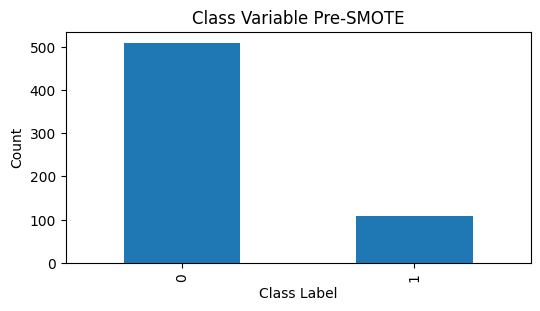

0    509
1    509
Name: class_0, dtype: int64


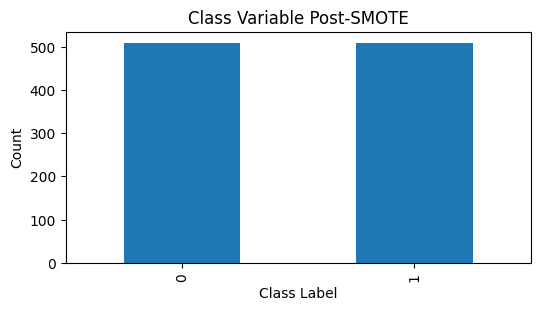

In [122]:
# fig, axs = plt.subplots(1, 2, figsize=(4, 4))


# Before balance Dataset is now balanced
print(train_df['class_1'].value_counts())
train_df['class_1'].value_counts().plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Variable Pre-SMOTE')
plt.figsize = (4,4)
plt.show()

X, y = oversample_data(X, y)
# print(X.shape, y.shape)

# Dataset is now balanced
print(y.value_counts())
y.value_counts().plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Variable Post-SMOTE')
plt.rcParams['figure.figsize'] = [6, 3]
# plt.figure(figsize = (1,1))
plt.show()

## Using PCA to remove features

### Using PCA

In [123]:
# X, X_pca = reduce_dimensions(X)
print(X.shape[1], y.shape)

57 (1018,)


Cumulative Variances (Percentage):
[54.60122479 61.89362176 67.24492594 71.66988424 74.77552586 77.27043951
 79.35137916 81.13438983 82.70027784 84.06106283 85.28776618 86.44415363
 87.43548938 88.37018353 89.26468496 90.12535616]
Number of components: 16


Text(0, 0.5, 'Explained variance (%)')

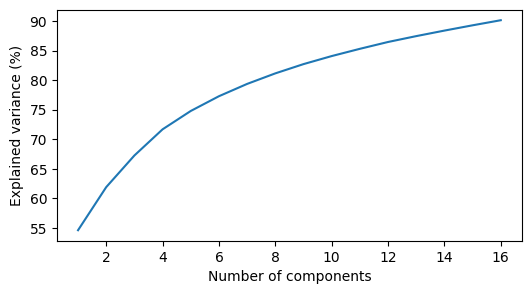

In [124]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)
pca.fit(X)
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')
# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [126]:
X, X_pca = reduce_dimensions(X)

n_pcs = X_pca.components_.shape[0]

most_important = [np.abs(X_pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_df.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_most_important_features = pd.DataFrame(dic.items(), columns = ['Principal Component', 'Feature'])

df_most_important_features.head()

,Principal Component,Feature
0,PC0,EJ_A
1,PC1,EL
2,PC2,CW
3,PC3,EL
4,PC4,GI


In [24]:
# import plotly.express as px
# from sklearn.decomposition import PCA


# exp_var_cumul = np.cumsum(X_pca.explained_variance_ratio_)

# px.area(
#     x=range(1, exp_var_cumul.shape[0] + 1),
#     y=exp_var_cumul,
#     labels={"x": "# Components", "y": "Explained Variance"}
# )

In [25]:
# import plotly.express as px
# components = X

# total_var = X_pca.explained_variance_ratio_[0:3].sum() * 100

# fig = px.scatter_3d(
#     components, x=0, y=1, z=2, color=y,
#     title=f'Total Explained Variance: {total_var:.2f}%',
#     labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
# )
# fig.show()

In [26]:
# X_pca = pca.transform(X)

# Modeling

### Custom Scorer

In [27]:
#CORRECT LOG LOSS TO USE
def log_loss(y_true, prob_pred):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_0 = y_true
    y_1 = -1 * (y_true - 1)

    p_0 = np.log(prob_pred + 1)
    p_1 = np.log(1 - prob_pred + 1)

    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [28]:
rf_log_loss_score = make_scorer(score_func=log_loss, greater_is_better=False)

### Support Vector Classification model

In [36]:
classifier = SVC(probability=True, tol=0.0000001)
classifier.fit(X, y)

test_df['class_0'] = classifier.predict_proba(X_test)[:, 0]
test_df['class_1'] = 1 - test_df['class_0']

In [37]:
test_df.reset_index()[['Id', 'class_0', 'class_1']].to_csv('submission.csv', index=False)

### make a cell here for integrating the Greeks dataset and include the splits
X_a, y_a -- y_a only class 0 and class a

X_b, y_b -- ""

X_c, y_c -- ""

### RF Regressor

In [38]:
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#cross_val_score(classifier, X, y, cv=3, scoring=log_loss_score)

grid1 = {
    'n_estimators': [200,300,400,500,600,700,800],
    # 'n_estimators': [500],
    'max_features': ['sqrt'],
    'max_depth' : [5,6,7, 8,9,10],
    # 'max_depth' : [6],
    'random_state' : [0]
}
## show start time
print(datetime.datetime.now())
## Grid Search function
skf = StratifiedKFold(n_splits=5)
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= skf, scoring = rf_log_loss_score, error_score = 'raise')
# CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= 5, error_score = 'raise')
CV_rfr.fit(X, y)
## show end time
print(datetime.datetime.now())

2023-06-24 20:16:22.768361


KeyboardInterrupt: ignored

In [67]:
# print(X_pca.shape, y.shape)

(1018, 16) (1018,)


In [39]:
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#cross_val_score(classifier, X, y, cv=3, scoring=log_loss_score)

grid1 = {
    'n_estimators': [200,300,400,500,600,700,800],
    # 'n_estimators': [500],
    'max_features': ['sqrt'],
    'max_depth' : [5,6,7, 8,9,10],
    # 'max_depth' : [6],
    'random_state' : [0]
}
## show start time
print(datetime.datetime.now())
skf = StratifiedKFold(n_splits=5)
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= skf, scoring = rf_log_loss_score, error_score = 'raise')
# CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= 5, error_score = 'raise')
CV_rfr.fit(X, y)

2023-06-24 20:16:41.467826


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise', estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt'],
                         'n_estimators': [200, 300, 400, 500, 600, 700, 800],
                         'random_state': [0]},
             scoring=make_scorer(log_loss, greater_is_better=False))

In [40]:
pred = CV_rfr.best_estimator_.predict(X)

N_0 = (y == 0).sum()
N_1 = (y == 1).sum()

y_0 = y
y_1 = -1 * (y - 1)

p_0 = np.log(pred + 1)
p_1 = np.log(1 - pred + 1)

log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2
log_loss

-0.6639246864598396

In [48]:
#CORRECT LOG LOSS TO USE
def log_loss(y_true, prob_pred):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_0 = y_true
    y_1 = -1 * (y_true - 1)

    p_0 = np.log(prob_pred + 1)
    p_1 = np.log(1 - prob_pred + 1)

    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [42]:
log_loss_rf = log_loss(y, pred)
print(log_loss_rf)

-0.6639246864598396


### Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over
params = {'C': [1,2,3], 'penalty': ['l2']}

# Create a grid search object
skf = StratifiedKFold(n_splits=5)

gs_LR = GridSearchCV(LogisticRegression(), param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_LR.fit(X, y)

# Print the best parameters found by the grid search

print(gs_LR.best_params_)

pred = gs_LR.best_estimator_.predict(X)

log_loss_rf = log_loss(y, pred)
print(log_loss_rf)

{'C': 3, 'penalty': 'l2'}
-0.6209727197157859


### KNN

In [ ]:
k_range = list(range(1, 31))
params = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(KNN(), param_grid=params, cv= skf, scoring = log_loss_score)

# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)